# Análisis

In [80]:
# !pip install pyvolutionary==2.4.2
# !pip install pycaret
# !pip install pycaret[full]
# !pip install scikit_learn==1.4

In [81]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from numpy.linalg import svd
import requests
import json


sscaler = StandardScaler()
rscaler = RobustScaler()
mmscaler = MinMaxScaler()
mascaler = MaxAbsScaler()

le = LabelEncoder()

def lencoder(df, col, lenc=False, train=True):
    if train:
        label = le.fit_transform(df[col])
        df[col] = pd.to_numeric(label)
        return df,le
    elif lenc != False:
        label = lenc.transform(df[col])
        df[col] = pd.to_numeric(label)
        return df
    else:
        print('Nothing done')
        return df



In [82]:
def run_kfold_model (X,y,K=10,graph=True):
    regr = LinearRegression()
    kf = KFold(n_splits=5)
    s=1
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regr.fit(X_train, y_train)
        print('Slice '+str(s)+' score: '+str(regr.score(X_test, y_test)))
        y_pred = regr.predict(X_test)
        if graph:
            plt.scatter(y_test, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
            plt.show()
        s+=1
    return(regr)

In [83]:
def scores (model, X_train, X_test, y_test, y_pred, graph=True):
    MAE=metrics.mean_absolute_error(y_test, y_pred)
    MSE=metrics.mean_squared_error(y_test, y_pred)
    RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    CV_RMSE= (RMSE/np.average(y_test))*100
    R2=metrics.r2_score(y_test, y_pred)
    ACC=metrics.accuracy_score
    REC=metrics.recall_score
    PREC=metrics.precision_score

    print('MAE:'+str(MAE))
    print('MSE:'+str(MSE))
    print('RMSE:'+str(RMSE))
    print('CV(RMSE): '+str(CV_RMSE))
    print('R2:'+str(R2))
    print('Accuracy:'+str(ACC))
    print('Recall:'+str(REC))
    print('Precision:'+str(PREC))

    # print('Training score: '+str(model.score(X_train, y_train))) #(Accuracy or R2)
    # print('Test score: '+str(model.score(X_test, y_train)))
    if graph == True:
        plt.scatter(y_train, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
        plt.show()

In [84]:
import dask.dataframe as dd

In [85]:
from ast import literal_eval
def clean(x):
    return literal_eval(x)

In [86]:
pd.set_option("mode.copy_on_write", True)
pd.options.mode.copy_on_write = True

In [87]:
import math

def dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    df = pd.concat([df,tDummy],axis=1).reindex(df.index)
    return(df)

def just_dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    return(tDummy)

def just_dummies_steps(df, col, ix):
    num_chunks = math.ceil(len(df) / ix)  # Calculate number of chunks
    all_dummies = []  # Store results from each chunk

    for i in range(num_chunks):
        start = i * ix  # Starting index for the current chunk
        end = (i + 1) * ix  # Ending index for the current chunk

        chunk = df.loc[start:end-1] # Select chunk of data for the dummies
        chunk_dummies = just_dummies(chunk, col)  # Apply just_dummies to chunk
        all_dummies.append(chunk_dummies)  # Append the output to the list

    # Concatenate all dummy DataFrames horizontally
    final_dummies = pd.concat(all_dummies, axis=1)
    return final_dummies

# Checkpoint 1

In [ ]:
# data = pd.read_excel('mozilla-bugs-all.xlsx')
# data.describe

In [ ]:
def json_data(URL,params):
    headers = {"Accept" : "application/json"}
    resp = requests.get(URL, params= params, headers= headers)
    df = pd.DataFrame()
    if resp.status_code != 200:
        print('error: ' + str(resp.status_code))
    else:
        print('Success')
        bugs = resp.text
        data = json.loads(bugs)
        df = pd.json_normalize(data['bugs'])
    return(df)

params ={
    "include_fields" : ["id"
                        ,"summary"
                        ,"status"
                        ,"description"
                        ,"type"
                        ,"classification"
                        ,"product"
                        ,"component"
                        ,"priority"
                        ,"assigned_to"
                        ,"resolution"
                        ,"creation_time"
                        ,"last_change_time"
                        ,"severity"
                        ,"version"
                        ]
    ,"product" : "Core"
    # ,"status" : ["VERIFIED","RESOLVED","CLOSED","UNCONFIRMED","NEW"]
    ,"limit" : 10000
    ,"order": "opendate DESC"
}
URL = "https://bugzilla.mozilla.org/rest/bug"


In [ ]:
params["status"] = "RESOLVED"
params.pop("status", None)

test_df = json_data(URL,params)
print(test_df.columns.to_list())
test_df.tail()

In [ ]:
# for i in test_df.columns.to_list():
#     print("Column "+i+" unique values:")
#     # print(test_df[i].unique())
#     print(test_df[i].value_counts())

#     print()


In [ ]:
test_df.groupby(['resolution']).sum().plot(kind='pie', y='id', autopct='%1.0f%%', labeldistance=None)
from datetime import datetime

print(test_df['creation_time'].min())
datetime.now() - pd.to_datetime(pd.to_datetime(test_df['creation_time'][test_df['resolution']=='FIXED']).values.astype(np.int64).mean())
plt.pie(x=test_df['resolution'].unique(), labels=test_df['resolution'].value_counts())
plt.show()

plt.title('Category Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

test_df.to_csv("dataset_20240907.csv")
test_df.date = pd.to_datetime(test_df.date).values.astype(np.int64)

test_df = pd.DataFrame(pd.to_datetime(test_df.groupby('column').mean().date))

# Checkpoint 2

In [ ]:
data = pd.read_csv('dataset_20240827.csv')
data.describe

<bound method NDFrame.describe of       Unnamed: 0 resolution product         creation_time priority  \
0              0        NaN    Core  2024-08-27T07:10:15Z       P5   
1              1        NaN    Core  2024-08-27T07:09:56Z       --   
2              2        NaN    Core  2024-08-27T06:56:08Z       --   
3              3        NaN    Core  2024-08-27T06:13:19Z       P5   
4              4        NaN    Core  2024-08-27T05:29:11Z       --   
...          ...        ...     ...                   ...      ...   
9995        9995        NaN    Core  2024-03-23T18:04:58Z       --   
9996        9996        NaN    Core  2024-03-23T18:01:29Z       --   
9997        9997        NaN    Core  2024-03-23T17:57:21Z       P3   
9998        9998        NaN    Core  2024-03-23T17:56:41Z       P3   
9999        9999        NaN    Core  2024-03-23T17:55:13Z       P3   

     classification    type      last_change_time  \
0        Components  defect  2024-08-27T07:10:15Z   
1        Components

In [ ]:
#import nltk
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
import math
import re

def NLProcess (text):

    # print('Original text: ',data.iloc[1]['description'])
    #print("====================== starting ======================")
    ######################################################################### Tokenised
    mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
    tokenizer = word_tokenize
    tokenised = tokenizer(text)
    #print('Tokenised: ',tokenised)
    retokenised = mwe_tokenizer.tokenize(tokenised)
    # retokenised = [token.replace('_', '') for token in retokenised]
    #print('ReTokenised: ',retokenised)

    ######################################################################### Lower-case converted
    normalised = [word.lower() for word in retokenised]
    #print('Normalised: ',normalised)

    ######################################################################### Punctuation marks removed
    unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
    #print('Punctuation marks removed: ',unmarked)

    ######################################################################### Stop-words removed
    stop_words = set(stopwords.words('english'))
    filtered = [word for word in unmarked if word not in stop_words]
    #print('Stop-words removed: ',filtered)

    ######################################################################### Lemmatised
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
    #print('Lemmatised: ',lemmatised)

    return lemmatised


In [ ]:
# def dfNLProcess (df,column):
#     for index, row in df.iterrows():
#         text = row[column]
#         # print('Original text: ',data.iloc[1]['description'])
#         #print("====================== starting ======================")
#         ######################################################################### Tokenised
#         mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
#         tokenizer = word_tokenize
#         tokenised = tokenizer(text)
#         #print('Tokenised: ',tokenised)
#         retokenised = mwe_tokenizer.tokenize(tokenised)
#         # retokenised = [token.replace('_', '') for token in retokenised]
#         #print('ReTokenised: ',retokenised)

#         ######################################################################### Lower-case converted
#         normalised = [word.lower() for word in retokenised]
#         #print('Normalised: ',normalised)

#         ######################################################################### Punctuation marks removed
#         unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
#         #print('Punctuation marks removed: ',unmarked)

#         ######################################################################### Stop-words removed
#         stop_words = set(stopwords.words('english'))
#         filtered = [word for word in unmarked if word not in stop_words]
#         #print('Stop-words removed: ',filtered)

#         ######################################################################### Lemmatised
#         lemmatizer = WordNetLemmatizer()
#         lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
#         #print('Lemmatised: ',lemmatised)

#         lemmatised
#         ncol = 'P'+col
#         df2 = pd.DataFrame({ncol:lemmatised})
#         df2 = dummies(df2)


In [ ]:
# dfNLProcess(data,'summary')

In [ ]:
# for i in range(10):
#     NLProcess(data.iloc[i]['description'])

data['Psummary'] = data['summary'].map(NLProcess)

# type(data['summary'])

In [ ]:
data['Pdescription'] = data['description'].fillna('').map(NLProcess)

In [ ]:
#data.loc[data['description'].str.contains('//crash-stats.mozilla.org/report/index/768c5c44-57c5-4746-890c-9af820240811', case=False, na=False)]

In [ ]:
data.head()

,Unnamed: 0,resolution,product,creation_time,priority,classification,type,last_change_time,component,summary,...,id,severity,version,assigned_to_detail.nick,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.real_name,assigned_to_detail.email,Psummary,Pdescription
0,0,NaN,Core,2024-08-27T07:10:15Z,P5,Components,defect,2024-08-27T07:10:15Z,Widget,Intermittent widget/tests/browser/browser_test...,...,1915086,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, widgettestsbrowserbrowser_test_...","[filed, nfay, mozillacom, parsed, log, http, t..."
1,1,NaN,Core,2024-08-27T07:09:56Z,--,Components,defect,2024-08-27T07:12:28Z,Networking: DNS,"Bad name, functionality for network.trr.exclud...",...,1915085,--,Firefox 129,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[bad, name, functionality, networktrrexcludeet...","[user, agent, mozilla50, macintosh, intel, mac..."
2,2,NaN,Core,2024-08-27T06:56:08Z,--,Components,task,2024-08-27T07:02:38Z,WebRTC: Audio/Video,Request sRGB colorspace from ScreenCapturerSck,...,1915082,NaN,unspecified,pehrsons,489889,apehrson@mozilla.com,Andreas Pehrson [:pehrsons],apehrson@mozilla.com,"[request, srgb, colorspace, screencapturersck]","[screencapturekit, doc, http, developerappleco..."
3,3,NaN,Core,2024-08-27T06:13:19Z,P5,Components,defect,2024-08-27T06:17:48Z,Panning and Zooming,Intermittent gfx/layers/apz/test/mochitest/tes...,...,1915078,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, gfxlayersapztestmochitesttest_g...","[filed, nfay, mozillacom, parsed, log, http, t..."
4,4,NaN,Core,2024-08-27T05:29:11Z,--,Components,defect,2024-08-27T06:25:14Z,DOM: Core & HTML,Removing meta viewport tag has no effect,...,1915077,--,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[removing, meta, viewport, tag, effect]","[str, 1, open, site, meta, viewport, element, ..."


In [ ]:
data.to_csv("dataset_20240907_plusP.csv")

# Checkpoint 3 Psummary

In [ ]:
data = pd.read_csv('dataset_20240907_plusP.csv', converters={'Psummary': clean})
data.head()

,Unnamed: 0.1,Unnamed: 0,resolution,product,creation_time,priority,classification,type,last_change_time,component,...,id,severity,version,assigned_to_detail.nick,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.real_name,assigned_to_detail.email,Psummary,Pdescription
0,0,0,NaN,Core,2024-08-27T07:10:15Z,P5,Components,defect,2024-08-27T07:10:15Z,Widget,...,1915086,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, widgettestsbrowserbrowser_test_...","['filed', 'nfay', 'mozillacom', 'parsed', 'log..."
1,1,1,NaN,Core,2024-08-27T07:09:56Z,--,Components,defect,2024-08-27T07:12:28Z,Networking: DNS,...,1915085,--,Firefox 129,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[bad, name, functionality, networktrrexcludeet...","['user', 'agent', 'mozilla50', 'macintosh', 'i..."
2,2,2,NaN,Core,2024-08-27T06:56:08Z,--,Components,task,2024-08-27T07:02:38Z,WebRTC: Audio/Video,...,1915082,NaN,unspecified,pehrsons,489889,apehrson@mozilla.com,Andreas Pehrson [:pehrsons],apehrson@mozilla.com,"[request, srgb, colorspace, screencapturersck]","['screencapturekit', 'doc', 'http', 'developer..."
3,3,3,NaN,Core,2024-08-27T06:13:19Z,P5,Components,defect,2024-08-27T06:17:48Z,Panning and Zooming,...,1915078,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, gfxlayersapztestmochitesttest_g...","['filed', 'nfay', 'mozillacom', 'parsed', 'log..."
4,4,4,NaN,Core,2024-08-27T05:29:11Z,--,Components,defect,2024-08-27T06:25:14Z,DOM: Core & HTML,...,1915077,--,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[removing, meta, viewport, tag, effect]","['str', '1', 'open', 'site', 'meta', 'viewport..."


In [ ]:
data.drop(axis=1, columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
data.head()

,resolution,product,creation_time,priority,classification,type,last_change_time,component,summary,description,...,id,severity,version,assigned_to_detail.nick,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.real_name,assigned_to_detail.email,Psummary,Pdescription
0,NaN,Core,2024-08-27T07:10:15Z,P5,Components,defect,2024-08-27T07:10:15Z,Widget,Intermittent widget/tests/browser/browser_test...,**Filed by:** nfay [at] mozilla.com\n**Parsed ...,...,1915086,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, widgettestsbrowserbrowser_test_...","['filed', 'nfay', 'mozillacom', 'parsed', 'log..."
1,NaN,Core,2024-08-27T07:09:56Z,--,Components,defect,2024-08-27T07:12:28Z,Networking: DNS,"Bad name, functionality for network.trr.exclud...",User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,...,1915085,--,Firefox 129,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[bad, name, functionality, networktrrexcludeet...","['user', 'agent', 'mozilla50', 'macintosh', 'i..."
2,NaN,Core,2024-08-27T06:56:08Z,--,Components,task,2024-08-27T07:02:38Z,WebRTC: Audio/Video,Request sRGB colorspace from ScreenCapturerSck,[The ScreenCaptureKit docs](https://developer....,...,1915082,NaN,unspecified,pehrsons,489889,apehrson@mozilla.com,Andreas Pehrson [:pehrsons],apehrson@mozilla.com,"[request, srgb, colorspace, screencapturersck]","['screencapturekit', 'doc', 'http', 'developer..."
3,NaN,Core,2024-08-27T06:13:19Z,P5,Components,defect,2024-08-27T06:17:48Z,Panning and Zooming,Intermittent gfx/layers/apz/test/mochitest/tes...,**Filed by:** nfay [at] mozilla.com\n**Parsed ...,...,1915078,S4,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[intermittent, gfxlayersapztestmochitesttest_g...","['filed', 'nfay', 'mozillacom', 'parsed', 'log..."
4,NaN,Core,2024-08-27T05:29:11Z,--,Components,defect,2024-08-27T06:25:14Z,DOM: Core & HTML,Removing meta viewport tag has no effect,STR;\n\n1. Open any sites having a meta viewpo...,...,1915077,--,unspecified,nobody,1,nobody@mozilla.org,Nobody; OK to take it and work on it,nobody@mozilla.org,"[removing, meta, viewport, tag, effect]","['str', '1', 'open', 'site', 'meta', 'viewport..."


In [ ]:
# from sklearn.feature_selection import mutual_info_classif

In [ ]:
type(data.iloc[0]['Psummary'])
# type(data['Psummary'])

list

In [ ]:
exploded = data.explode('Psummary')

In [ ]:
filter='^\d+$'
notfilter='^(?!'+filter+').*$'
exploded_filtered = exploded.loc[exploded['Psummary'].str.contains(notfilter)]

In [ ]:
checkit = just_dummies(exploded_filtered,'Psummary')

In [ ]:
checkit.index.name = 'index'

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkit.head()

,Psummary_00f,Psummary_01f,Psummary_04347e67c6f87ee7a33c8ed8103aecebac6c3888,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0dc559f060db0d62d95f424e3fd26a5f673b2f6b,Psummary_0e30966b198ad28943799eaf5b3b08100b6f70c3,Psummary_0kb,Psummary_0px,...,Psummary_zoomteams,Psummary_zoomus,Psummary_zstd,Psummary_zstd_dctx_setparameter,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_zwusermsgwaitformultipleobjectsex,Psummary_zydis,Psummary_ñ,Psummary_㜱㜸㤱㠰㤴㜶㔰㔰
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# prefix='Psummary_'
# filter=prefix+'\d+$'
# notfilter='^(?!'+filter+').*$'
# print(len(checkit.filter(regex=(notfilter)).columns.tolist()))
# # print(checkit.filter(regex=(notfilter)).columns.tolist())

In [ ]:
checkot = checkit.groupby(['index'], observed=True).sum()

In [ ]:
checkot['nindex'] = checkot.index

In [ ]:
checkot.head()

,Psummary_00f,Psummary_01f,Psummary_04347e67c6f87ee7a33c8ed8103aecebac6c3888,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0dc559f060db0d62d95f424e3fd26a5f673b2f6b,Psummary_0e30966b198ad28943799eaf5b3b08100b6f70c3,Psummary_0kb,Psummary_0px,...,Psummary_zoomus,Psummary_zstd,Psummary_zstd_dctx_setparameter,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_zwusermsgwaitformultipleobjectsex,Psummary_zydis,Psummary_ñ,Psummary_㜱㜸㤱㠰㤴㜶㔰㔰,nindex
index,,,,,,,,,,,,,,,,,,,,,
2733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2733
2786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2786
8923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8923
8985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8985
1775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1775


In [ ]:
checket = checkot.compute()

KeyboardInterrupt: 

In [ ]:
checkit = checket.reset_index()

In [ ]:
checkit.head()

In [ ]:
# def rowgroupbyidnex(df):
#     rows = []
#     for i in len(df):
#         rows.append(df.iloc[i].groupby(checkit.index, observed=True).sum())





In [ ]:
checkit.to_csv('dataset_20240907_plusP_Psummary.csv')

# Checkpoint 4 Out of order

In [ ]:
data = pd.read_csv('dataset_20240907_plusP.csv', converters={'Pdescription': clean,'Psummary': clean})

In [ ]:
exploded = data.explode('Pdescription')
filter='^\d+$'
notfilter='^(?!'+filter+').*$'

exploded = exploded.loc[exploded['Pdescription'].notna()]

exploded_filtered = exploded.loc[exploded['Pdescription'].str.contains(notfilter)]

In [ ]:
exploded_filtered['nindex'] = exploded_filtered.index

In [ ]:
exploded_filtered = exploded_filtered.reset_index()

In [ ]:
checkit = just_dummies_steps(exploded_filtered[['nindex','Pdescription']],'Pdescription',1000)

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkot = checkit.groupby([checkit.index], observed=True).sum()
checkot['nindex'] = checkot.index
checket = checkot.compute()
checkit = checket.reset_index()
checkit.to_csv('dataset_20240907_plusP_Pdescription.csv')

# Checkpoint 5 TFIDF

In [ ]:
data = pd.read_csv('dataset_20240907_plusP.csv', converters={'Pdescription': clean,'Psummary': clean})

In [ ]:
summary = pd.read_csv('dataset_20240907_plusP_Psummary.csv')

In [ ]:
summary.drop(axis=1, columns=['Unnamed: 0','nindex','index'], inplace=True)
summary.head()

,Psummary_00f,Psummary_01f,Psummary_04347e67c6f87ee7a33c8ed8103aecebac6c3888,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0dc559f060db0d62d95f424e3fd26a5f673b2f6b,Psummary_0e30966b198ad28943799eaf5b3b08100b6f70c3,Psummary_0kb,Psummary_0px,...,Psummary_zoomteams,Psummary_zoomus,Psummary_zstd,Psummary_zstd_dctx_setparameter,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_zwusermsgwaitformultipleobjectsex,Psummary_zydis,Psummary_ñ,Psummary_㜱㜸㤱㠰㤴㜶㔰㔰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data['Psummary']=data['Psummary'].tolist()

In [ ]:
data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))

In [ ]:
summary.head()

,Psummary_00f,Psummary_01f,Psummary_04347e67c6f87ee7a33c8ed8103aecebac6c3888,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0dc559f060db0d62d95f424e3fd26a5f673b2f6b,Psummary_0e30966b198ad28943799eaf5b3b08100b6f70c3,Psummary_0kb,Psummary_0px,...,Psummary_zoomteams,Psummary_zoomus,Psummary_zstd,Psummary_zstd_dctx_setparameter,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_zwusermsgwaitformultipleobjectsex,Psummary_zydis,Psummary_ñ,Psummary_㜱㜸㤱㠰㤴㜶㔰㔰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform(df[col])

  # Select the first five documents from the data set
  tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
  tf_idf.columns = vectorizer.get_feature_names_out()
  tfidf_matrix = tf_idf.T
  tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, 10001)]
  tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

  # Top words
  tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

  # Print the first 10 words
  # print(tfidf_matrix.drop(columns=['count']).head(10))

  return tfidf_matrix


In [ ]:
# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

In [ ]:
filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

In [ ]:
wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

,bug1,bug2,bug3,bug4,bug5,bug6,bug7,bug8,bug9,bug10,...,bug9993,bug9994,bug9995,bug9996,bug9997,bug9998,bug9999,bug10000,count,words
intermittent,0.239473,0.0,0.0,0.185069,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379.114540,Psummary_intermittent
bug,0.260809,0.0,0.0,0.201557,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,354.356753,Psummary_bug
tracking,0.262563,0.0,0.0,0.202912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.168633,Psummary_tracking
single,0.264538,0.0,0.0,0.204439,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,349.340710,Psummary_single
sync,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213.736062,Psummary_sync


In [ ]:
wordlst.to_csv('dataset_20240907_plusP_Wordlst_tfidf.csv')

In [ ]:
summary.head()

In [ ]:
summary = summary[wordlst['words']]
summary.head()

In [ ]:
summary.tail()

In [ ]:
mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

# Checkpoint 6

In [130]:
mergeddata = pd.read_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

In [131]:
mergeddata.head()
mergeddata['resolution'] = mergeddata['resolution'].fillna('')
mergeddata['severity'] = mergeddata['severity'].fillna('SN/A')
# mergeddata['resolution'] = mergeddata['resolution'].astype(str)

In [132]:
mergeddata.drop([
'Unnamed: 0.2',
'Unnamed: 0.1',
'Unnamed: 0',
'Unnamed: 0.2',
'Unnamed: 0.1',
'Unnamed: 0',
'summary',
'description',
'Psummary',
'Pdescription',
'assigned_to',
'assigned_to_detail.real_name',
'assigned_to_detail.nick',
'assigned_to_detail.name',
'assigned_to_detail.email'
],axis=1,inplace=True)

mergeddata.head()

,resolution,product,creation_time,priority,classification,type,last_change_time,component,status,id,...,Psummary_doc,Psummary_shadow,Psummary_specific,Psummary_exit,Psummary_unexpected,Psummary_wb,Psummary_cpu,Psummary_wasm,Psummary_webrender,Psummary_start
0,,Core,2024-08-27T07:10:15Z,P5,Components,defect,2024-08-27T07:10:15Z,Widget,NEW,1915086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,,Core,2024-08-27T07:09:56Z,--,Components,defect,2024-08-27T07:12:28Z,Networking: DNS,UNCONFIRMED,1915085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,,Core,2024-08-27T06:56:08Z,--,Components,task,2024-08-27T07:02:38Z,WebRTC: Audio/Video,ASSIGNED,1915082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,,Core,2024-08-27T06:13:19Z,P5,Components,defect,2024-08-27T06:17:48Z,Panning and Zooming,NEW,1915078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,Core,2024-08-27T05:29:11Z,--,Components,defect,2024-08-27T06:25:14Z,DOM: Core & HTML,NEW,1915077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
mergeddata = mergeddata[mergeddata['priority']!= '--']
# mergeddata.loc[mergeddata['priority']=='--'].head()


mergeddata = mergeddata[mergeddata['severity']!= '--']
mergeddata['severity'].replace('normal','S3')
# mergeddata.loc[mergeddata['severity']=='--'].head()

len(mergeddata)

4110

In [134]:
mergeddata['severity'].unique()

array(['S4', 'SN/A', 'S3', 'S2', 'S1'], dtype=object)

In [135]:
tipos = mergeddata.dtypes
# tipos['columna']=tipos.index
# tipos.rename({'0':'tipo'})
tipos = tipos.to_frame()

# columnas = tipos.loc[tipos['tipo']=='object'].index
columnas = tipos.loc[tipos[0]!='float'].index.to_list()
columnas

for columna in columnas:
    print(columna)
    print(mergeddata[columna].apply(type).unique())
    print('--------------------------------------------')

resolution
[<class 'str'>]
--------------------------------------------
product
[<class 'str'>]
--------------------------------------------
creation_time
[<class 'str'>]
--------------------------------------------
priority
[<class 'str'>]
--------------------------------------------
classification
[<class 'str'>]
--------------------------------------------
type
[<class 'str'>]
--------------------------------------------
last_change_time
[<class 'str'>]
--------------------------------------------
component
[<class 'str'>]
--------------------------------------------
status
[<class 'str'>]
--------------------------------------------
id
[<class 'int'>]
--------------------------------------------
severity
[<class 'str'>]
--------------------------------------------
version
[<class 'str'>]
--------------------------------------------
assigned_to_detail.id
[<class 'int'>]
--------------------------------------------


# Prepare

In [136]:
dmergeddata = dummies(mergeddata,'resolution').copy()
dmergeddata = dummies(dmergeddata,'product')
dmergeddata = dummies(dmergeddata,'classification')
dmergeddata = dummies(dmergeddata,'type')
dmergeddata = dummies(dmergeddata,'component')
dmergeddata, lemodel = lencoder(dmergeddata,'priority')
dmergeddata, lemodel = lencoder(dmergeddata,'severity')
dmergeddata, lemodel = lencoder(dmergeddata,'version')
dmergeddata['creation_time'] = pd.to_datetime(mergeddata['creation_time'])
dmergeddata['last_change_time'] = pd.to_datetime(mergeddata['last_change_time'])
dmergeddata['assigned_to_detail.id'] = mergeddata['assigned_to_detail.id']

In [137]:
print(mergeddata.columns.tolist())
print(dmergeddata.columns.tolist())
ogcols = mergeddata[['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'priority'
,'severity'
,'assigned_to_detail.id']]
dmergeddata = dmergeddata.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
],axis=1)

['resolution', 'product', 'creation_time', 'priority', 'classification', 'type', 'last_change_time', 'component', 'status', 'id', 'severity', 'version', 'assigned_to_detail.id', 'Psummary_intermittent', 'Psummary_bug', 'Psummary_tracking', 'Psummary_single', 'Psummary_sync', 'Psummary_pr', 'Psummary_wptsync', 'Psummary_test', 'Psummary_wpt', 'Psummary_tier', 'Psummary_failure', 'Psummary_add', 'Psummary_crash', 'Psummary_firefox', 'Psummary_code', 'Psummary_new', 'Psummary_remove', 'Psummary_fix', 'Psummary_update', 'Psummary_failing', 'Psummary_args', 'Psummary_assertion', 'Psummary_nt', 'Psummary_http', 'Psummary_implement', 'Psummary_support', 'Psummary_unknown', 'Psummary_window', 'Psummary_mozilla', 'Psummary_use', 'Psummary_video', 'Psummary_page', 'Psummary_error', 'Psummary_set', 'Psummary_meta', 'Psummary_text', 'Psummary_perma', 'Psummary_using', 'Psummary_element', 'Psummary_file', 'Psummary_work', 'Psummary_does_not', 'Psummary_event', 'Psummary_etp', 'Psummary_export', 'Ps

In [16]:
def columns_with_nan(df):
    # Obtener una lista de los nombres de las columnas
    columns = df.columns.to_list()

    # Filtrar las columnas que tienen valores NaN
    columns_with_nan = [col for col in columns if df[col].isna().any()]

    return columns_with_nan

In [17]:
columns_with_nan(dmergeddata)

['Psummary_intermittent',
 'Psummary_bug',
 'Psummary_tracking',
 'Psummary_single',
 'Psummary_sync',
 'Psummary_pr',
 'Psummary_wptsync',
 'Psummary_test',
 'Psummary_wpt',
 'Psummary_tier',
 'Psummary_failure',
 'Psummary_add',
 'Psummary_crash',
 'Psummary_firefox',
 'Psummary_code',
 'Psummary_new',
 'Psummary_remove',
 'Psummary_fix',
 'Psummary_update',
 'Psummary_failing',
 'Psummary_args',
 'Psummary_assertion',
 'Psummary_nt',
 'Psummary_http',
 'Psummary_implement',
 'Psummary_support',
 'Psummary_unknown',
 'Psummary_window',
 'Psummary_mozilla',
 'Psummary_use',
 'Psummary_video',
 'Psummary_page',
 'Psummary_error',
 'Psummary_set',
 'Psummary_meta',
 'Psummary_text',
 'Psummary_perma',
 'Psummary_using',
 'Psummary_element',
 'Psummary_file',
 'Psummary_work',
 'Psummary_does_not',
 'Psummary_event',
 'Psummary_etp',
 'Psummary_export',
 'Psummary_strict',
 'Psummary_webkit',
 'Psummary_enable',
 'Psummary_make',
 'Psummary_dom',
 'Psummary_bugswebkitorgshow_bugcgi',
 'P

In [18]:
def rows_with_nan(df, column_name):
    # Filtrar las filas donde la columna especificada tiene valores NaN
    rows_with_nan = df[df[column_name].isna()]
    return rows_with_nan
rows_with_nan(dmergeddata,'Psummary_intermittent')
print(rows_with_nan(dmergeddata,'Psummary_intermittent').index)
dmergeddata.drop(index=9999, inplace=True)

Index([9999], dtype='int64')


# PyCaret

In [ ]:
from pycaret.classification import *

dataset = mergeddata

data = dataset.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

clf1 = setup(data, target='severity')

# Compare models
best_model = compare_models()

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
tuned_model = tune_model(best_model)

NameError: name 'tune_model' is not defined

In [ ]:
evaluate_model(tuned_model)

# XGBoost

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef

def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Recall
    recall = recall_score(y_test, y_pred,average='weighted')
    print("Recall:", recall)

    # Precision
    precision = precision_score(y_test, y_pred,average='weighted')
    print("Precision:", precision)

    # F1 Score
    f1 = f1_score(y_test, y_pred,average='weighted')
    print("F1 Score:", f1)

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("MCC:", mcc)


In [ ]:
def run_kfold_model (model, X,y,K=10,graph=True):
    regr = LinearRegression()
    kf = KFold(n_splits=5)
    s=1
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        print('Slice '+str(s)+' score: '+str(regr.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        scores(y_test, y_pred)
        if graph:
            plt.scatter(y_test, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
            plt.show()
        s+=1
    return(regr)

In [ ]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import DMatrix, XGBClassifier

dataset = mergeddata

X = dataset.drop(['severity','priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

Y = dataset['severity']

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# dtrain = DMatrix(X_train, label=y_train, enable_categorical=True)

# params = {
#     # 'objective': 'binary:logistic',
#     'objective': 'multi:softmax',
#     'num_class': 4,
#     'tree_method': 'hist'  # 'hist' or 'approx' are recommended for categorical data
# }

# fit model on training data
model = XGBClassifier(objective= 'multi:softmax', num_class= 4)
model.fit(X_train, y_train)
# model = xgb.train(params, dtrain, num_boost_round=10)

# make predictions for test data
# dpredict = xgb.DMatrix(X_test, enable_categorical=True)

# y_pred = model.predict(dpredict)


# predictions = [round(value) for value in y_pred]

# scores(model, X_train, X_test, y_train, y_test)

# run_kfold_model(model, X_train, y_train)

y_pred = model.predict(X_test)
scores(y_test, y_pred)

Accuracy: 0.8572587185725872
Recall: 0.8572587185725872
Precision: 0.8462048189113937
F1 Score: 0.8503490062200572
Cohen's Kappa: 0.7705153801901797
MCC: 0.7711123744607169


# PyCaret top 7

In [146]:
from pycaret.classification import *

dataset = dmergeddata

data = dataset.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
],axis=1)

clf1 = setup(data, target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()


KeyError: "['priority', 'resolution', 'product', 'creation_time', 'classification', 'type', 'last_change_time', 'component', 'status'] not found in axis"

In [ ]:
import pickle as pk
i=0
for m in [
          'rf',
          'gbc',
          'et',
          'xgboost',
          'catboost',
          'lightgbm',
          'dt']:
  print(model[i].get_params())
  name=m+'.pkl'
  with open(name, "wb") as file: # file is a variable for storing the newly created file, it can be anything.
    pk.dump(model, file) # Dump function is used to write the object into the created file in byte format.
  i+=1

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 8853, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 8853, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


# PyCaret Optimise

In [ ]:
tuned_model = tune_model(model[3])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8160,0.0000,0.8160,0.8075,0.8100,0.7052,0.7071
1,0.8576,0.0000,0.8576,0.8470,0.8494,0.7706,0.7728
2,0.8472,0.0000,0.8472,0.8366,0.8395,0.7564,0.7586
3,0.8715,0.9553,0.8715,0.8590,0.8625,0.7950,0.7975
4,0.8611,0.9627,0.8611,0.8611,0.8535,0.7776,0.7816
5,0.8681,0.9642,0.8681,0.8563,0.8600,0.7903,0.7922
6,0.8711,0.0000,0.8711,0.8507,0.8591,0.7904,0.7922
7,0.8362,0.0000,0.8362,0.8555,0.8333,0.7420,0.7465
8,0.8502,0.0000,0.8502,0.8438,0.8457,0.7607,0.7619


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 40,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 8853,
 'reg_alpha': 1e-06,
 'reg_lambda': 3,
 'sampling_method': None,
 'scale_pos_weight': 3.5,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [ ]:
# evaluate_model(tuned_model)

# CUDA

In [ ]:
# Remove existing CUDA installation (use with caution)
!apt-get --purge remove nvidia*

# Download and install CUDA 11
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get -y install cuda-11-0

# Verify CUDA 11 installation
!nvcc --version

# Install cuDF 23.08 (compatible with CUDA 11)
!pip install cudf-cu11==23.08 --extra-index-url=https://pypi.nvidia.com

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-560-server-560.28.03' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-imex' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'

In [ ]:
!nvidia-smi
!nvcc --version

Wed Oct  2 02:44:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              31W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!ls -la /usr/local/lib/python3.10/dist-packages | grep -i ylibraft
!rm -rf /usr/local/lib/python3.10/dist-packages/-ylibraft-cu11*

drwxr-xr-x   9 root root     4096 Oct  2 02:20 pylibraft
drwxr-xr-x   2 root root     4096 Oct  2 02:20 pylibraft_cu11-23.8.0.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 02:20 pylibraft_cu11.libs
drwxr-xr-x   3 root root     4096 Oct  2 02:06 pylibraft_cu12-24.8.1.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 02:06 pylibraft_cu12.libs
drwxr-xr-x  10 root root     4096 Oct  2 02:06 ~ylibraft
drwxr-xr-x   3 root root     4096 Oct  2 01:12 ~ylibraft_cu11-24.8.1.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 01:12 ~ylibraft_cu11.libs


In [ ]:
!pip install cudf-cu11==23.08
!pip install cuml-cu11==23.08

In [ ]:
!pip install cudf-cu11==23.08 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu11==23.08 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached https://pypi.nvidia.com/cuml-cu11/cuml_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1081.6 MB)
  Using cached dask_cuda-23.8.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached https://pypi.nvidia.com/dask-cudf-cu11/dask_cudf_cu11-23.8.0-py3-none-any.whl (81 kB)
  Using cached distributed-2023.7.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached https://pypi.nvidia.com/raft-dask-cu11/raft_dask_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (214.7 MB)
  Using cached https://pypi.nvidia.com/pylibraft-cu11/pylibraft_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (555.6 MB)
Using cached dask_cuda-23.8.0-py3-none-any.whl (122 kB)
Using cached distributed-2023.7.1-py3-none-any.whl (985 kB)
  Attempting uninstall: distributed
    Found existing installation: distribut

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

In [ ]:
import cudf
import cuml

mergeddata = cudf.from_pandas(mergeddata)

from cuml.model_selection import GridSearchCV

ImportError: libcublas.so.11: cannot open shared object file: No such file or directory

# Optimising

In [ ]:
dataset = mergeddata

X = dataset.drop(['severity','priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

Y = dataset['severity']

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

# model[3].save_model('xgb_model.model')

# modelxgb = cuml.xgboost.XGBClassifier()

# modelxgb.load_model('xgb_model.model')

# with open('xgboost.pkl', 'rb') as f:
#   modelxgb = pickle.load(f)

modelxgb = model[3]

param_grid = {
    # 'max_depth': [3, 4, 5, 10],
    'booster': ['dart'],
    'max_depth': [3],
    # 'subsample': [0.1, 0.6, 0.8, 1.0]
    'subsample': [1.0],
    # 'colsample_bylevel': [0.6, 0.8, 1.0]
    'colsample_bylevel': [0.6],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
    'colsample_bytree': [0.8],
    # 'min_child_weight': [1, 5, 100]
    'min_child_weight': [0.5],
    # 'reg_alpha': [1, 5, 100],
    # 'reg_lambda': [1, 5, 100]
    'reg_alpha': [1],
    'reg_lambda': [5],
    'gamma': [0.1],
    # 'gamma': [0, 0.1, 0.2, 0.3]
    # 'n_estimators': [50, 100, 250, 500],
    # 'learning_rate': [0.01, 0.2, 0.5]
    'n_estimators': [250],
    'learning_rate': [0.2],
    'scale_pos_weight': [3.5],
    # 'scale_pos_weight': [1, 5, 10],
    'max_delta_step': [5],
    'tree_method': ['auto']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=modelxgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate the model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Best Model Accuracy: {accuracy:.4f}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


# PyVolutionary

In [ ]:
# !pip install pyvolutionary==2.4.2

In [ ]:
from pyvolutionary.evolution import Evolution
from pyvolutionary.models import OptimizationResult
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Assuming you have your data loaded as `X` and `Y`
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

def objective_function(chromosome):
    # Create an XGBClassifier with hyperparameters from the chromosome
    model = XGBClassifier(
        max_depth=int(chromosome[0]),
        subsample=chromosome[1],
        colsample_bytree=chromosome[2],
        learning_rate=chromosome[3],
        colsample_bylevel=chromosome[4],
        reg_alpha=chromosome[5],
        reg_lambda=chromosome[6],
        gamma=chromosome[7],
        n_estimators=int(chromosome[8]),
        scale_pos_weight=chromosome[9],
        min_child_weight=chromosome[10],
        max_delta_step=chromosome[11],
        tree_method='hist'
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return OptimizationResult(
        costs=[1 - accuracy],  # Minimize (1 - accuracy)
        constraints=[],  # Add constraints if needed
    )

# Define search space for hyperparameters
search_space = [
    (3, 10),  # max_depth range (integers)
    (0.1, 1.0),  # subsample range (floats)
    (0.5, 1.0),  # colsample_bytree range (floats)
    (0.01, 0.5),  # learning_rate range (floats)
    (0.1, 1.0),  # 'colsample_bylevel': [0.1, 0.6, 1.0]]
    (1, 100), # 'reg_alpha': [1, 5, 100],
    (1, 100), # 'reg_lambda': [1, 5, 100]
    (0, 0.3), # 'gamma': [0, 0.1, 0.2, 0.3]
    (40, 500), # 'n_estimators': [50, 100, 250, 500],
    (1, 10)  # 'scale_pos_weight': [1, 5, 10],
    (0.5, 100), # 'min_child_weight': [1, 5, 100]
    (1, 10), # max_delta_step

]

# Initialize and run Evolution
evolution = Evolution(
    objective_function=objective_function,
    search_space=search_space,
    # ... other Evolution parameters (population size, generations, etc.)
)
result = evolution.evolve()

# Print the best hyperparameters and fitness
print(f"Best hyperparameters: {result.best_chromosome}")
print(f"Best fitness (accuracy): {1 - result.best_costs[0]}")

# Other balancing techniques

In [ ]:
# !pip install imbalanced-learn==0.11.0

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

In [ ]:
mergeddata['severity'].value_counts()


,count
severity,
3,2122
2,1185
4,700
1,98
0,4


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

dataset = mergeddata.drop(mergeddata[mergeddata['severity'] == 0].index)

# Assuming 'severity' is your target variable
mapping = {1: 0, 2: 1, 3: 2, 4: 3}  # Create a mapping dictionary
dataset['severity'] = dataset['severity'].map(mapping)

X = dataset.drop(['severity','priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

Y = dataset['severity']

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bylevel': 0.6,
    'colsample_bytree': 0.8,
    'min_child_weight': 0.5,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'gamma': 0.1,
    'n_estimators': 250,
    'learning_rate': 0.2,
    'scale_pos_weight': 1,
    'max_delta_step': 5,
    'tree_method': 'hist',
    'random_state': 42

}

modelxgb = XGBClassifier(params)

# Resampling techniques
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print('ROS')
modelxgb.fit(X_ros, y_ros) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print('RUS')
modelxgb.fit(X_rus, y_rus) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

# smote = SMOTE(random_state=42, k_neighbors=2)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# print('SMOTE')
# modelxgb.fit(X_smote, y_smote) # Use resampled data
# y_pred = modelxgb.predict(X_test)
# print(accuracy_score(y_test, y_pred))

adasyn = ADASYN(random_state=42, )
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print('ADASYN')
modelxgb.fit(X_adasyn, y_adasyn) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))
# Apply resampling to training data

# smoteenn = SMOTEENN(random_state=42)
# X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
# print('SMOTENN')
# modelxgb.fit(X_smoteenn, y_smoteenn) # Use resampled data
# y_pred = modelxgb.predict(X_test)
# print(accuracy_score(y_test, y_pred))


# Example: Train and evaluate with SMOTE





ROS
0.8165584415584416
RUS
0.6972402597402597


ValueError: Input X contains NaN.
ADASYN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Heatmap

In [138]:
# mergeddataS = dmergeddata
mergeddataS = dmergeddata[dmergeddata.columns.drop(list(dmergeddata.filter(regex='^Psummary')))]

In [139]:
mergeddataS.columns.tolist()

['id',
 'severity',
 'version',
 'assigned_to_detail.id',
 'resolution_',
 'resolution_DUPLICATE',
 'resolution_FIXED',
 'resolution_INCOMPLETE',
 'resolution_INVALID',
 'resolution_WONTFIX',
 'resolution_WORKSFORME',
 'product_Core',
 'classification_Components',
 'type_defect',
 'type_enhancement',
 'type_task',
 'component_Audio/Video',
 'component_Audio/Video: MediaStreamGraph',
 'component_Audio/Video: Playback',
 'component_Audio/Video: Recording',
 'component_Audio/Video: Web Codecs',
 'component_Audio/Video: cubeb',
 'component_CSS Parsing and Computation',
 'component_CSS Transitions and Animations',
 'component_Cycle Collector',
 'component_DLL Services',
 'component_DOM: Animation',
 'component_DOM: Bindings (WebIDL)',
 'component_DOM: CSS Object Model',
 'component_DOM: Content Processes',
 'component_DOM: Copy & Paste and Drag & Drop',
 'component_DOM: Core & HTML',
 'component_DOM: Credential Management',
 'component_DOM: Device Interfaces',
 'component_DOM: Editor',
 'co

In [ ]:
summary.drop(axis=1, columns=['Unnamed: 0','nindex','index'], inplace=True)
summary.head()

data['Psummary']=data['Psummary'].tolist()

data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))


from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df[col])

    # Select the first five documents from the data set
    tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
    tf_idf.columns = vectorizer.get_feature_names_out()
    tfidf_matrix = tf_idf.T
    tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, 10001)]
    tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

    # Top words
    tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

    # Print the first 10 words
    # print(tfidf_matrix.drop(columns=['count']).head(10))

    return tfidf_matrix

# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

summary = summary[wordlst['words']]
summary.head()

mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

['resolution',
 'product',
 'creation_time',
 'priority',
 'classification',
 'type',
 'last_change_time',
 'component',
 'status',
 'assigned_to',
 'id',
 'severity',
 'version',
 'assigned_to_detail.nick',
 'assigned_to_detail.id',
 'assigned_to_detail.name',
 'assigned_to_detail.email',
 'resolution_',
 'resolution_DUPLICATE',
 'resolution_FIXED',
 'resolution_INCOMPLETE',
 'resolution_INVALID',
 'resolution_WONTFIX',
 'resolution_WORKSFORME',
 'product_Core',
 'classification_Components',
 'type_defect',
 'type_enhancement',
 'type_task',
 'component_Audio/Video',
 'component_Audio/Video: MediaStreamGraph',
 'component_Audio/Video: Playback',
 'component_Audio/Video: Recording',
 'component_Audio/Video: Web Codecs',
 'component_Audio/Video: cubeb',
 'component_CSS Parsing and Computation',
 'component_CSS Transitions and Animations',
 'component_Cycle Collector',
 'component_DLL Services',
 'component_DOM: Animation',
 'component_DOM: Bindings (WebIDL)',
 'component_DOM: CSS Object

In [58]:
# Assuming you have your DataFrame loaded as 'dataHM'

# Get all columns
all_columns = mergeddataS.columns.tolist()

# Get numerical columns
numerical_columns = mergeddataS.select_dtypes(include=['number']).columns.tolist()

# Get non-numerical columns
non_numerical_columns = list(set(all_columns) - set(numerical_columns))

print("Columns that cannot be converted to float:", non_numerical_columns)

Columns that cannot be converted to float: ['resolution', 'status', 'creation_time', 'last_change_time', 'classification', 'component', 'type', 'product']


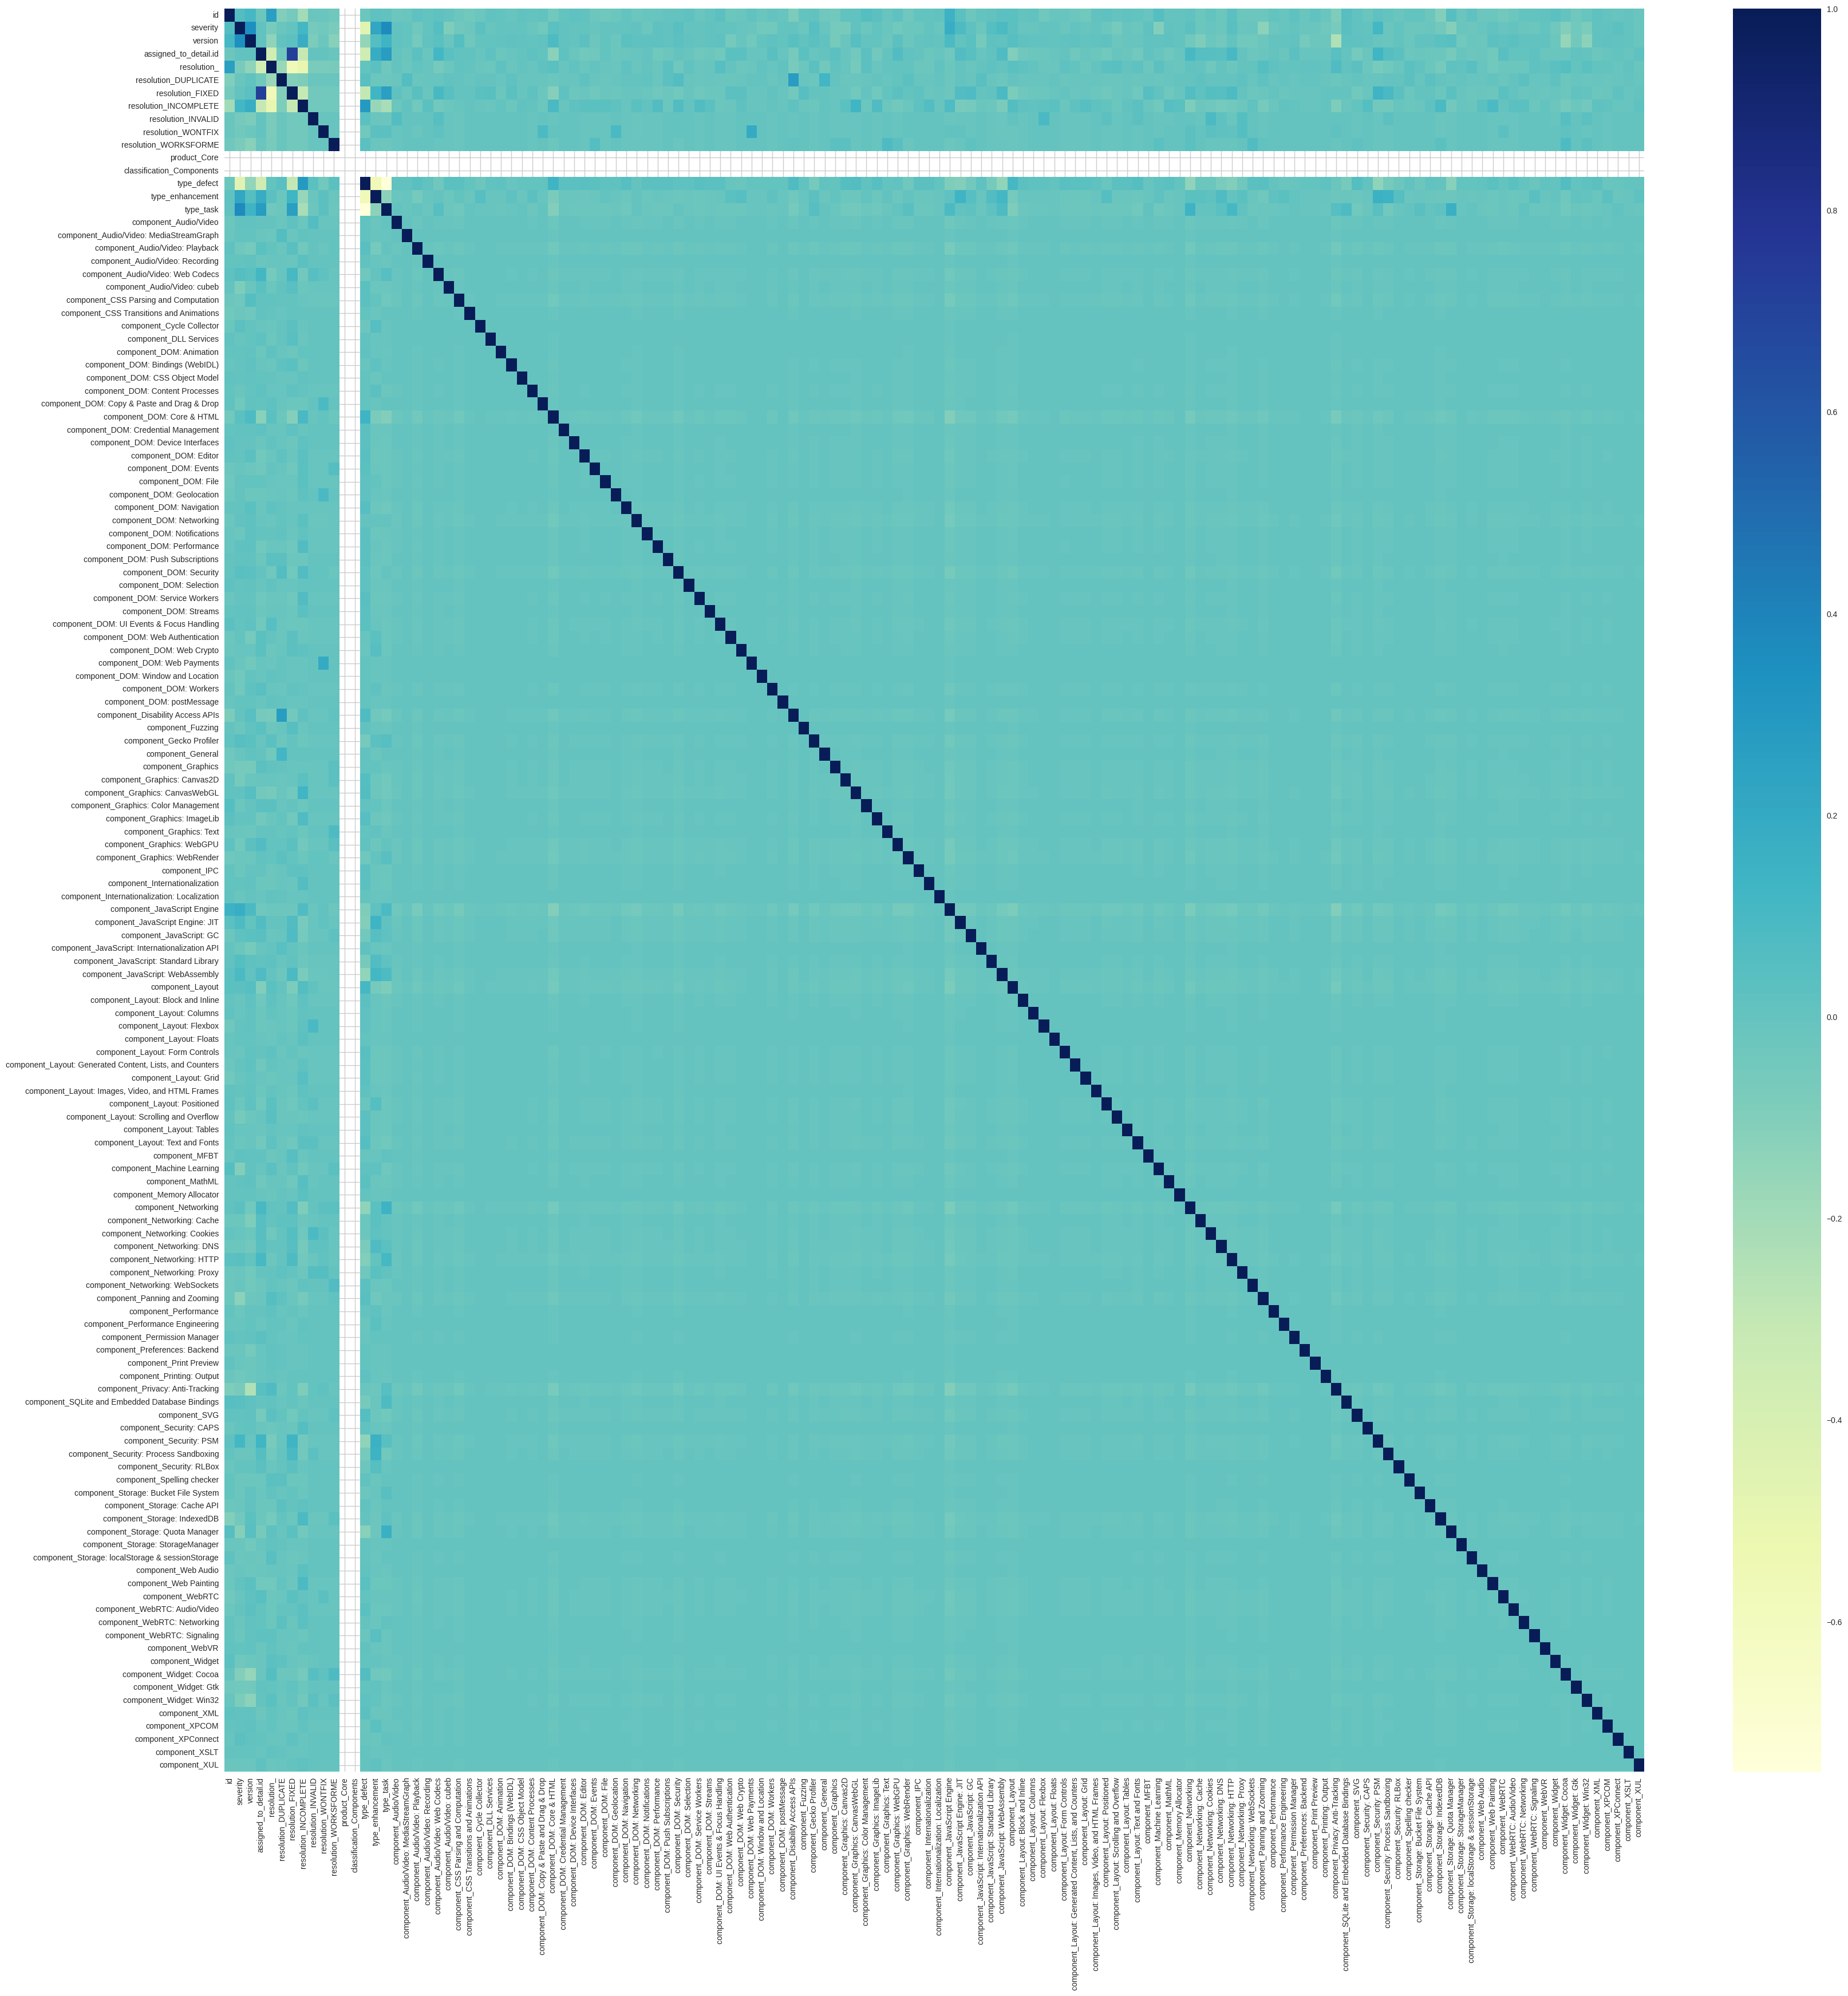

In [140]:
# Import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# Import file with data
dataHM = mergeddataS.copy()
# mergeddata[mergeddata.columns.drop(list(mergeddata.filter(regex='^Psummary')))]

# Print data that will be plotted
# Columns shown here are selected by corr() since
# they are ideal for the plot
# print(dataHM.corr(numeric_only=True))

# Plotting correlation heatmap
fig, ax = mp.subplots(figsize=(40, 40))
dataplot = sb.heatmap(dataHM.corr(numeric_only=True), cmap="YlGnBu", annot=False, ax=ax)

# Displaying heatmap
mp.show()


In [149]:
threshold = 0.01
correlations = mergeddataS.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = mergeddataS[selected_features]

severity                          1.000000
type_defect                       0.457833
type_task                         0.373606
version                           0.350315
type_enhancement                  0.216963
                                    ...   
component_DOM: Service Workers    0.001301
component_DOM: File               0.000671
component_DOM: Selection          0.000115
product_Core                           NaN
classification_Components              NaN
Name: severity, Length: 136, dtype: float64
Index(['severity', 'type_defect', 'type_task', 'version', 'type_enhancement',
       'component_JavaScript Engine', 'component_Panning and Zooming',
       'resolution_INCOMPLETE', 'component_Security: PSM',
       'component_Storage: Quota Manager', 'component_Machine Learning',
       'component_Widget: Cocoa', 'component_Audio/Video: cubeb',
       'component_JavaScript: WebAssembly', 'component_JavaScript Engine: JIT',
       'component_Widget: Win32', 'resolution_WORKSFORME

In [ ]:
from pycaret.classification import *

data = mergeddata

clf1 = setup(data, target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()

,Description,Value
0,Session id,1743
1,Target,severity
2,Target type,Multiclass
3,Original data shape,"(4110, 90)"
4,Transformed data shape,"(4110, 90)"
5,Transformed train set shape,"(2877, 90)"
6,Transformed test set shape,"(1233, 90)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7708,0.0000,0.7708,0.7772,0.7654,0.6298,0.6305
1,0.8021,0.0000,0.8021,0.7997,0.7992,0.6834,0.6843
2,0.8229,0.0000,0.8229,0.8242,0.8196,0.7169,0.7184
3,0.8056,0.0000,0.8056,0.7990,0.7988,0.6848,0.6856
4,0.7708,0.9124,0.7708,0.7692,0.7677,0.6309,0.6324
5,0.8021,0.9394,0.8021,0.8087,0.8030,0.6870,0.6892
6,0.7986,0.9262,0.7986,0.7872,0.7919,0.6751,0.6758
7,0.8188,0.0000,0.8188,0.8221,0.8124,0.7059,0.7063
8,0.8084,0.0000,0.8084,0.7997,0.8036,0.6900,0.6903


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7743,0.0000,0.7743,0.7745,0.7657,0.6330,0.6359
1,0.8021,0.0000,0.8021,0.7979,0.7975,0.6821,0.6837
2,0.8021,0.0000,0.8021,0.7889,0.7914,0.6836,0.6865
3,0.8160,0.0000,0.8160,0.8070,0.8088,0.7015,0.7029
4,0.7743,0.0000,0.7743,0.7690,0.7660,0.6340,0.6379
5,0.8299,0.0000,0.8299,0.8422,0.8285,0.7305,0.7328
6,0.8021,0.0000,0.8021,0.7822,0.7858,0.6787,0.6836
7,0.8293,0.0000,0.8293,0.8227,0.8253,0.7250,0.7252
8,0.8049,0.0000,0.8049,0.7990,0.7999,0.6878,0.6890


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:38:00
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


Processing:   0%|          | 0/4 [00:00<?, ?it/s]